# Brisbane QVPR, get associated events windows 

* Create iterators over the 6 traverses (located in data/*)
* Get the associated beginning of each traverses (from https://github.com/Tobias-Fischer/ensemble-event-vpr/blob/master/correspondence_event_camera_frame_camera.py)
* Iterate over a the files to get sampled points and save them as a dictionnary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils.gps_utils import get_gps, getDistanceFromLatLongKm, sampleItineraryFromDistance
from utils.event_readers import FixedDurationEventReader, FixedSizeEventReader

In [2]:
from pathlib import Path
Path("./output").mkdir(parents=True, exist_ok=True)
Path("./output/rgb").mkdir(parents=True, exist_ok=True)
Path("./output/event_rgb").mkdir(parents=True, exist_ok=True)

In [3]:
nmea_paths = {
    'sunset1': "nmea/20200421_170039-sunset1_concat.nmea",
    'sunset2': "nmea/20200422_172431-sunset2_concat.nmea",
    'daytime': "nmea/20200424_151015-daytime_concat.nmea",
    'morning': "nmea/20200428_091154-morning_concat.nmea",
    'sunrise': "nmea/20200429_061912-sunrise_concat.nmea",
    'night': "nmea/20200427_181204-night_concat.nmea"
}

video_paths = {
    'sunset1': "videos/20200421_170039-sunset1_concat.mp4",
    'sunset2': "videos/20200422_172431-sunset2_concat.mp4",
    'daytime': "videos/20200424_151015-daytime_concat.mp4",
    'morning': "videos/20200428_091154-morning_concat.mp4",
    'sunrise': "videos/20200429_061912-sunrise_concat.mp4",
    'night': "videos/20200427_181204-night_concat.mp4"
}

event_paths = {
   'sunset1': "data/dvs_vpr_2020-04-21-17-03-03.zip",
    'sunset2': "data/dvs_vpr_2020-04-22-17-24-21.zip",
    'daytime': "data/dvs_vpr_2020-04-24-15-12-03.zip",
    'morning': "data/dvs_vpr_2020-04-28-09-14-11.zip",
    'sunrise': "data/dvs_vpr_2020-04-29-06-20-23.zip",
    'night': "data/dvs_vpr_2020-04-27-18-13-29.zip"
}

frame_paths = {
    'sunset1': "rosbagsdvs_vpr_2020-04-21-17-03-03/frames/",
    'sunset2': "rosbagsdvs_vpr_2020-04-22-17-24-21/frames/",
    'daytime': "rosbagsdvs_vpr_2020-04-24-15-12-03/frames/",
    'morning': "rosbagsdvs_vpr_2020-04-28-09-14-11/frames/",
    'sunrise': "rosbagsdvs_vpr_2020-04-29-06-20-23/frames/",
    'night': "rosbagsdvs_vpr_2020-04-27-18-13-29/frames/"
}

video_beginning = {
    'sunset1': 1587452582.35,
    'sunset2': 1587540271.65,
    'daytime': 1587705130.80,
    'morning': 1588029265.73,
    'sunrise': 1588105232.91,
    'night': 1587975221.10
}

In [4]:
SAMPLING_DISTANCE = 0.3 # 0.3km

coordinates = {}
sampledPoints = {}

for traverse in nmea_paths:
    coordinates[traverse] = get_gps(nmea_paths[traverse])
    
for traverse in coordinates:
    longitudes = coordinates[traverse].T[1]
    latitudes = coordinates[traverse].T[0]
    timestamps = coordinates[traverse].T[2]
    sampledPoints[traverse] = sampleItineraryFromDistance(latitudes, longitudes, SAMPLING_DISTANCE)

    # Remove first and last points
    sampledPoints[traverse] = sampledPoints[traverse][0:-1]

Breaking at 577
Breaking at 565
Breaking at 556
Breaking at 569
Breaking at 573
Breaking at 571


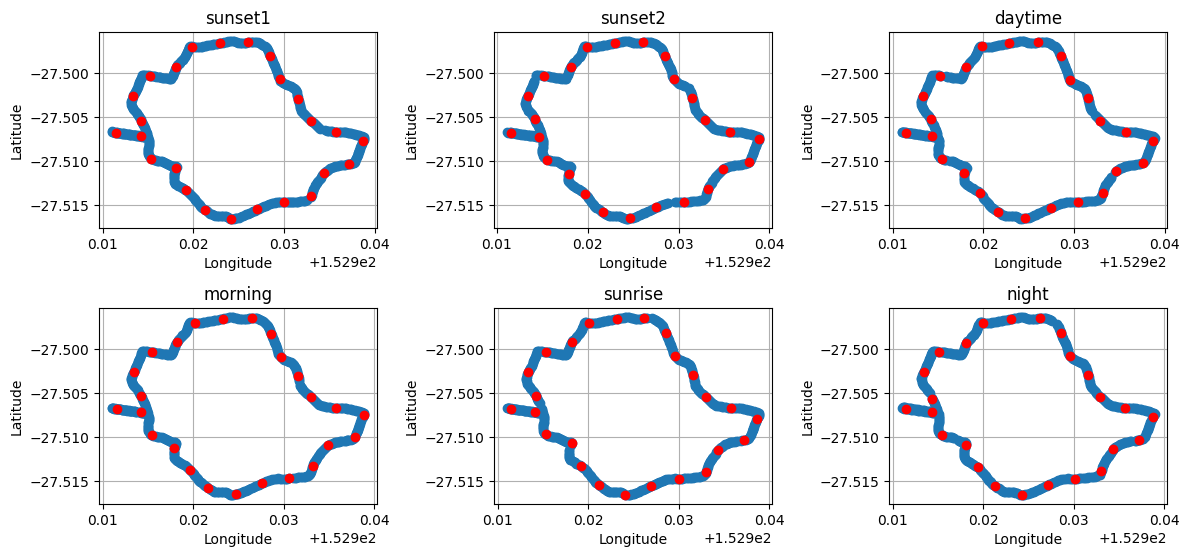

In [5]:
plt.figure(figsize=(12,8))
for index, traverse in enumerate(coordinates):
    longitudes = coordinates[traverse].T[1]
    latitudes = coordinates[traverse].T[0]
    plt.subplot(3,3,index+1)
    plt.plot(longitudes, latitudes, marker='o', linestyle='-')
    for point in sampledPoints[traverse]:
        plt.plot(longitudes[point], latitudes[point], marker='o', color='r')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.title(f"{traverse}")

plt.tight_layout()

# Matching timestamps between frames and GPS 

In [6]:
import os
from os.path import join, basename
from os import listdir

timestampGps = {}
timestampFrame = {}
timestampFilePath = {}

for traverse in video_beginning:
    timestampGps[traverse] = [t + video_beginning[traverse] for t in coordinates[traverse][:,2]]
    timestampFrame[traverse] = sorted([float(os.path.splitext(basename(f))[0]) for f in listdir(frame_paths[traverse]) if f.endswith('.png')])
    timestampFilePath[traverse] = sorted([join(frame_paths[traverse], f) for f in listdir(frame_paths[traverse]) if f.endswith('.png')])
  

In [7]:
def get_timestamp_matches(timestamps, timestamps_to_match):
    timestamps_matched = np.array([np.abs(timestamps - ts).argmin() for ts in timestamps_to_match])
    return timestamps_matched

In [8]:
matchedTimestamp = {}
for traverse in timestampFrame:
   matchedTimestamp[traverse] = get_timestamp_matches(timestampFrame[traverse], timestampGps[traverse])

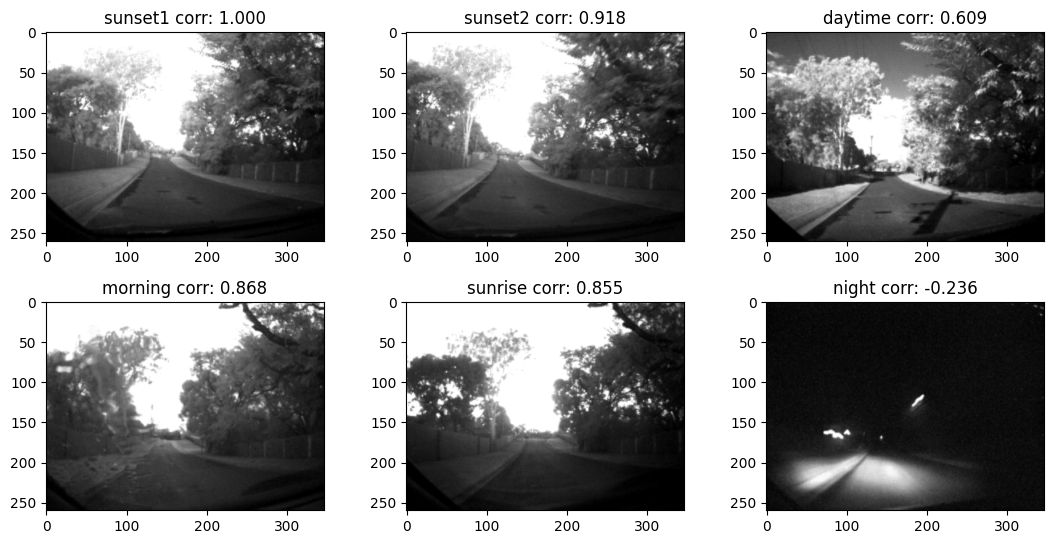

In [9]:
plt.figure(figsize=(11,8))

import pandas as pd
from PIL import Image


def getCorrelationValue(reference: np.array, comparison: np.array) -> float:
    reference = pd.DataFrame(reference.flatten())
    comparison = pd.DataFrame(comparison.flatten())
    result = reference.corrwith(comparison)
    return result[0]

for index, traverse in enumerate(sampledPoints):
    image_index = matchedTimestamp[traverse][sampledPoints[traverse][0]] # 0 reference points, 
    plt.subplot(3,3,index+1)
    # Reference match is sunset1
    if traverse == "sunset1":
        reference = np.array(Image.open(timestampFilePath[traverse][image_index]).convert('L'))

    if traverse == "morning": #OK
        frame = np.array(Image.open(timestampFilePath[traverse][image_index-6]).convert('L'))
        plt.imshow(frame, cmap="gray")
    elif traverse == "sunset2": #OK
        frame = np.array(Image.open(timestampFilePath[traverse][image_index-110]).convert('L'))
        plt.imshow(frame, cmap="gray")
    elif traverse == "sunrise": #OK
        frame = np.array(Image.open(timestampFilePath[traverse][image_index+32]).convert('L'))
        plt.imshow(frame, cmap="gray")
    elif traverse == "daytime": #OK
        frame = np.array(Image.open(timestampFilePath[traverse][image_index-20]).convert('L'))
        plt.imshow(frame, cmap="gray")
    else:
        frame = np.array(Image.open(timestampFilePath[traverse][image_index]).convert('L'))
        plt.imshow(frame, cmap="gray")

    plt.title(f"{traverse} corr: {getCorrelationValue(reference, frame):.3f}")

plt.tight_layout()

In [10]:
from maximise_correlation import maximiseSequenceWithReference, maximiseSequenceWithReferencePixelwise
from PIL import Image

def getTimestampFromFilePath(filepath):
    # Assuming the file path is from the timestampFilePath dictionnary
    return float(filepath.strip('.png\n').split("/")[-1])

calibratedTimestamps = {}
calibratedFilePaths = {}
for traverse in sampledPoints:
    calibratedTimestamps[traverse] = []
    calibratedFilePaths[traverse] = []

SEQUENCE_LENGTH = 110 # Check the N last and N next frames to find the best correlation for visual calibration

for i in range(len(sampledPoints['sunset1'])):
    
    plt.figure(figsize=(11,8))
    for index, traverse in enumerate(sampledPoints):
        
        image_index = matchedTimestamp[traverse][sampledPoints[traverse][i]]
        if traverse == "sunset1":
            plt.subplot(2,3,index+1)
            reference = np.array(Image.open(timestampFilePath[traverse][image_index]).convert('L'))
            plt.imshow(reference, cmap="gray")
            plt.title(f"{traverse} (reference)", color="blue")
            calibratedFilePaths[traverse].append(timestampFilePath[traverse][image_index])
        else:
            # 0 reference points, 
            plt.subplot(2,3,index+1)
            # Reference match is sunset1
            # Compute best match frame around the selected sampledPoint
            
            # Check if past and next values are not oob
            explorationalOffsetP = SEQUENCE_LENGTH
            explorationalOffsetN = SEQUENCE_LENGTH

            if len(timestampFilePath[traverse]) < image_index + SEQUENCE_LENGTH:
                explorationalOffsetP = len(timestampFilePath) #Check until the end of the array    
            if image_index - SEQUENCE_LENGTH < 0:
                explorationalOffsetN = 0 #Check from the beginning instead

            # Find the most correlated frame in the selected sequence
            placesAround = [np.asarray(Image.open(timestampFilePath[traverse][image_index + j]).convert('L')) for j in np.arange(-explorationalOffsetN,explorationalOffsetP)]
            bestCorrelation, corr, frameIndex = maximiseSequenceWithReferencePixelwise(reference, placesAround)
            #bestCorrelation, corr, frameIndex = maximiseSequenceWithReference(reference, placesAround)
          
            # Add in the calibratedTimestamp the timestamp of the best matching frame in the reference sequence
            
            calibratedTimestamps[traverse].append(getTimestampFromFilePath(timestampFilePath[traverse][frameIndex + image_index - SEQUENCE_LENGTH]))
            calibratedFilePaths[traverse].append(timestampFilePath[traverse][frameIndex + image_index  - SEQUENCE_LENGTH])

            plt.imshow(bestCorrelation, cmap="gray")
            plt.title(f"{traverse} Corr={corr:.3f}", color="blue")
            plt.suptitle(f"Place {i+1}", color="red")
        
    # Save frames path
    np.save("rgbFilePaths.npy", calibratedFilePaths)
    np.save("calibrated_timestamps.npy", calibratedTimestamps)
    plt.tight_layout()
    plt.savefig(f"output/rgb/place{i+1}.png", transparent=False)
    plt.close()

# Correlation between traverses on Place #1

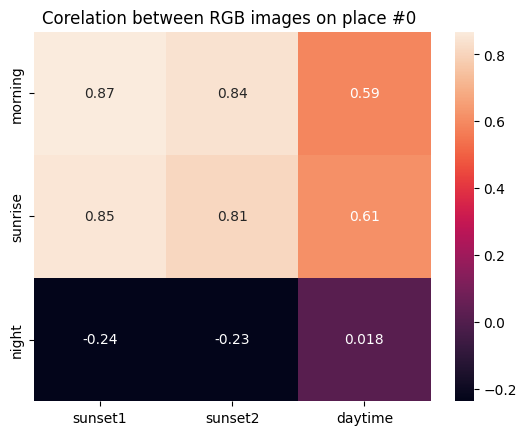

In [11]:
from PIL import Image
import pandas as pd
import seaborn as sn

selectedPoint = 0

offset_P1 = {
    "morning": -6,
    "sunset2": -110,
    "sunrise": 32,
    "daytime": -20,
    "night": 0,
    "sunset1": 0
}

P1_referencesX = {}
P1_referencesY = {}

for index, traverse in enumerate(sampledPoints):
    image_index = matchedTimestamp[traverse][sampledPoints[traverse][selectedPoint]] # 0 reference oints, 
    # Reference traverse is sunset1
    if index < 3:
        P1_referencesX[traverse] = np.asarray(Image.open(timestampFilePath[traverse][image_index + offset_P1[traverse]]).convert('L')).flatten() #Grayscaled and flattened
    else:
        P1_referencesY[traverse] = np.asarray(Image.open(timestampFilePath[traverse][image_index + offset_P1[traverse]]).convert('L')).flatten()

p1x = pd.DataFrame(P1_referencesX)
p1y = pd.DataFrame(P1_referencesY)
result = pd.concat([p1x, p1y], axis=1).corr()

plt.figure()
result = result[[key for key in P1_referencesX]].loc[[key for key in P1_referencesY]]
sn.heatmap(result, annot=True, )
plt.title(f"Corelation between RGB images on place #{selectedPoint} ")
plt.show()

# Get events

In [12]:
def convertListOfEventsIn2DVector(patternList, dimension=[260,346,2]):
    outVector = np.zeros((dimension[0], dimension[1], 3)) # 2 Channels, ON & OFF 
    for event in patternList:
        # Timestamp, X, Y, Polarity
        x = int(event[2])
        y = int(event[1])
        polarity = int(event[3])
        outVector[x][y][polarity] += 1
    return outVector

def addChannel(events):
    result = np.zeros((events.shape[0], events.shape[1], 3))
    result[:,:,0] = events[:,:,1] # Index 1 = ON on channel RED
    result[:,:,2] = events[:,:,0] # Index 0 = OFF on channel BLUE
    return result

def getVisualReprTimeWindow(events):   
    # Events should be dual channel array [W,H,2]
    maxChannel = np.argmax(events, axis=-1)
    maxValues = np.max(events, axis=-1)
    result = np.zeros_like(events)
    for x in range(events.shape[0]):
        for y in range(events.shape[1]):
            if maxValues[x][y] != 0:
                result[x][y][maxChannel[x][y]] = 1
    return addChannel(result)

Will use fixed size event windows with 100000 events
Output frame rate: variable
data/dvs_vpr_2020-04-21-17-03-03.zip


Text(0.5, 1.0, 'Brisbane Dataset, Event and RGB view')

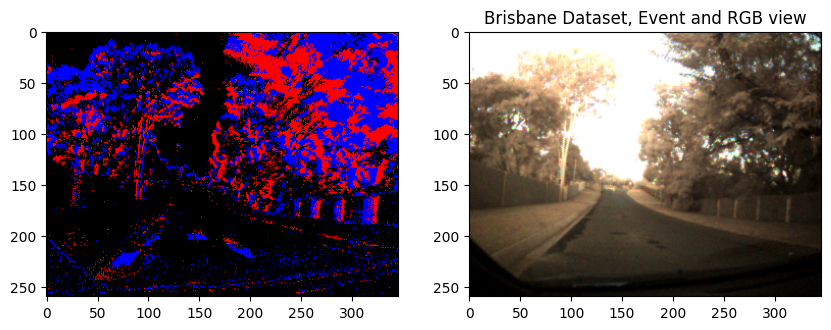

In [13]:
from utils.event_readers import FixedSizeEventReader

# Let's say that Place 1 index in sunset1 is 1587452613.977324 (visually high error just for testing purpose)

traverse = "sunset1"
eventReader = FixedSizeEventReader(event_paths["sunset1"], num_events=100000)
image_index = matchedTimestamp[traverse][sampledPoints[traverse][0]]

print(event_paths['sunset1'])

#Matched Timestamp 1587452614.353891849518
#Visual Timestamp 1587452613.977324

eventPattern = next(eventReader)
while eventPattern[0][0] < 1587452614.353891849518:
    try:
        eventPattern = next(eventReader)
    except StopIteration:
        break

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(getVisualReprTimeWindow(convertListOfEventsIn2DVector(eventPattern)))
plt.subplot(1,2,2)
plt.imshow(plt.imread(timestampFilePath[traverse][image_index]))
plt.title("Brisbane Dataset, Event and RGB view")

In [15]:
num_events = 40_000
eventPlaces = {}
BEGINNING_WINDOW = 0.5

# for traverse in sampledPoints:
#     eventPlaces[traverse] = []

for index, traverse in enumerate(sampledPoints):
    eventReader = FixedSizeEventReader(event_paths[traverse], num_events=num_events)
    eventPlaces = {}
    for i in range(len(sampledPoints['sunset1'])):
        eventPlaces[i] = []
        image_index = matchedTimestamp[traverse][sampledPoints[traverse][i]]
        eventPattern = next(eventReader)

        if traverse == "sunset1": # Reference key
            goalPlace = float(timestampFilePath[traverse][image_index].strip('.png\n').split("/")[-1])
            associatedFrame = timestampFilePath[traverse][image_index]
        else:
            goalPlace = calibratedTimestamps[traverse][i]
            associatedFrame = calibratedFilePaths[traverse][i]
    
        while eventPattern[0][0] < goalPlace - BEGINNING_WINDOW:
            try:
                eventPattern = next(eventReader)
            except StopIteration:
                break
        while eventPattern[0][0] < goalPlace + BEGINNING_WINDOW:    
            eventPlaces[i].append(eventPattern)
            try:
                eventPattern = next(eventReader)
            except StopIteration:
                break

    np.save(f"event_sliding_window_40k_{traverse}.npy", eventPlaces)

Will use fixed size event windows with 40000 events
Output frame rate: variable
Will use fixed size event windows with 40000 events
Output frame rate: variable
Will use fixed size event windows with 40000 events
Output frame rate: variable
Will use fixed size event windows with 40000 events
Output frame rate: variable
Will use fixed size event windows with 40000 events
Output frame rate: variable
Will use fixed size event windows with 40000 events
Output frame rate: variable


In [ ]:
import cv2
import numpy as np
from utils.event_readers import FixedSizeEventReader

eventReader = FixedSizeEventReader(event_paths["sunset1"], num_events=100000)

image_files = []
titles = []

for i in range(200):
    image_files.append(next(eventReader))
    titles.append(image_files[i][0][0])

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,10))

# Initialize the image plot
img = getVisualReprTimeWindow(convertListOfEventsIn2DVector(image_files[0]))
im = ax.imshow(img)

# Function to update the animation at each frame
def update_frame(i):
    img = getVisualReprTimeWindow(convertListOfEventsIn2DVector(image_files[i]))
    im.set_data(img)
    ax.set_title(titles[i])
    return [im]

# Create the animation
ani = animation.FuncAnimation(fig, update_frame, frames=len(image_files), interval=1000, blit=True)

# Save the animation as a GIF
ani.save("animation_with_titles.gif", writer="pillow")


In [ ]:
import itertools
from utils.visualisation import plotCorrMatrix, plotRecallAtN


rgbPlaces = np.load("rgbFilePaths.npy", allow_pickle=True).item()
eventPlaces = np.load("eventPlaces2.npy", allow_pickle=True).item()
traverses = list(rgbPlaces.keys())
duets = list(itertools.combinations(traverses, 2))



correlationMatricesRGB = []
correlationMatricesEvents = []

for duet in duets:
    comparisonTraverseRGB = []
    referenceTraverseRGB = []
    comparisonTraverseEvents = []
    referenceTraverseEvents = []
    
    # Correlation on RGB 
    for place in rgbPlaces[duet[0]]:
        comparisonTraverseRGB.append(np.asarray(Image.open(place).convert('L')))
    for place in rgbPlaces[duet[1]]:
        referenceTraverseRGB.append(np.asarray(Image.open(place).convert('L')))
    
    fig, ax = plt.subplots(figsize=(15,15))
    result, ax = plotCorrMatrix(ax, referenceTraverseRGB, comparisonTraverseRGB, duet[0], duet[1])
    plt.savefig(f"output/corr_matrix_rgb/{duet[0]}_{duet[1]}.png")
    plt.close()
    correlationMatricesRGB.append(result.to_numpy())

    # Correlation on events
    for place in eventPlaces[duet[0]]:
        comparisonTraverseEvents.append(convertListOfEventsIn2DVector(place))
    for place in eventPlaces[duet[1]]:
        referenceTraverseEvents.append(convertListOfEventsIn2DVector(place))
    
    fig, ax = plt.subplots(figsize=(15,15))
    result, ax = plotCorrMatrix(ax, referenceTraverseEvents, comparisonTraverseEvents, duet[0], duet[1])
    plt.savefig(f"output/corr_matrix_events/{duet[0]}_{duet[1]}.png")
    plt.close()
    correlationMatricesEvents.append(result.to_numpy())

# Save all combinations of 
np.save("correlationMatricesRGB.npy", correlationMatricesRGB)
np.save("correlationMatricesEvents.npy", correlationMatricesEvents)

In [ ]:
import itertools

traverses = list(video_beginning.keys())
duets = list(itertools.combinations(traverses, 2))
indice = 0
for duet in duets:
    if 'night' in duet:
        print(indice)
    indice += 1

print(duets)

(15, 25, 25)


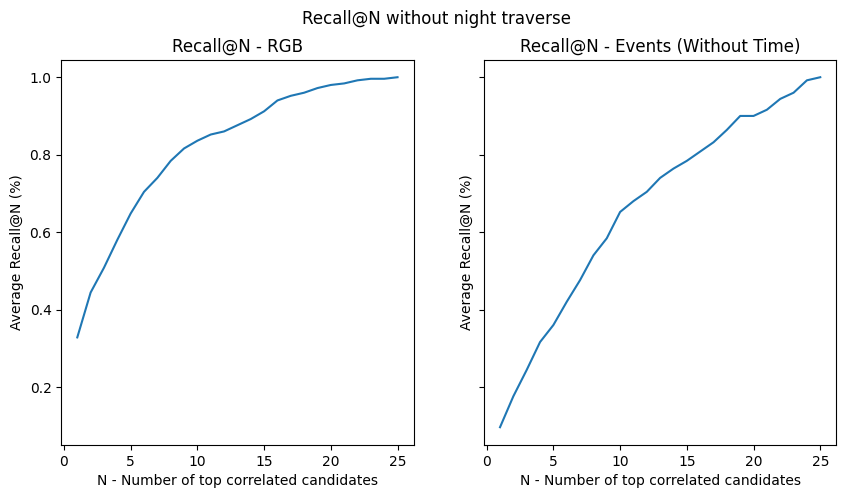

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from utils.visualisation import plotRecallAtN

correlationMatricesRGB = np.load("correlationMatricesRGB.npy")
correlationMatricesEvents = np.load("correlationMatricesEvents.npy")

print(correlationMatricesEvents.shape)

night_corr = [4,8,11,13,14]
correlationMatricesRGB = np.delete(correlationMatricesRGB, night_corr, axis=0)
correlationMatricesEvents = np.delete(correlationMatricesEvents, night_corr, axis=0)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))
plotRecallAtN(ax1, correlationMatricesRGB, 25)
plotRecallAtN(ax2, correlationMatricesEvents, 25)

ax1.set_title("Recall@N - RGB")
ax2.set_title("Recall@N - Events (Without Time)")
plt.suptitle("Recall@N without night traverse")
plt.show()

## Event Correlation over time

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from utils.visualisation import plotCorrMatrix

eventPlaces = np.load("eventPlaces2.npy", allow_pickle=True).item()
bins = 10

t0 = eventPlaces['sunset1'][0][0][0]
t1 = eventPlaces['sunset1'][0][-1][0]

bins = np.arange(1000,10000,1000)
bins

traverses = list(eventPlaces.keys())
duets = list(itertools.combinations(traverses, 2))

correlationMatricesEvents = {}
for duet in duets:
        correlationMatricesEvents[f"{duet[0]}-{duet[1]}"] = []


lastIndex = 0
for index in bins:
        for duet in duets:
                comparisonTraverseEvents = []
                referenceTraverseEvents = []

                for place in eventPlaces[duet[0]]:
                        comparisonTraverseEvents.append(convertListOfEventsIn2DVector(place[lastIndex:index]))
                for place in eventPlaces[duet[1]]:
                        referenceTraverseEvents.append(convertListOfEventsIn2DVector(place[lastIndex:index]))
        
                if len(comparisonTraverseEvents) == 0:
                        print(eventPlaces[duet[0]][lastIndex:index])

                fig, ax = plt.subplots(figsize=(15,15))
                result, ax = plotCorrMatrix(ax, referenceTraverseEvents, comparisonTraverseEvents, duet[0], duet[1])
                #plt.savefig(f'output/corr_matrix_event_timesteps/{duet[0]}-{duet[1]}-{index}.png')
                plt.close()
                correlationMatricesEvents[f"{duet[0]}-{duet[1]}"].append(result.to_numpy())
        lastIndex = index


In [ ]:
meanCorrelation = []
for correlation in correlationMatricesEvents:
    meanCorrelation.append((np.asarray(correlationMatricesEvents[correlation]).mean(axis=0)))

fig, ax = plt.subplots(figsize=(8,8))
plotRecallAtN(ax, meanCorrelation, 25)
plt.show()

## Compute Recall@N with events and a specific timewindow

In [ ]:
eventPlaces = np.load("eventPlaces2.npy", allow_pickle=True).item()

window_duration = [44, 66, 88, 120, 140, 280, 500, 1000]


t0 = eventPlaces['sunset1'][0][50000][0]
t1 = eventPlaces['sunset1'][0][-1][0]

print(t1 - t0)



convertListOfEventsIn2DVector('')
